In [2]:
import pandas as pd
'''
Read Data to get asset names
'''
file_path = "CBdata.xlsx"
xls = pd.read_excel(file_path, sheet_name=None, header=None,engine='openpyxl')
Name_df = xls["NaME"]

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import scipy.stats as stats
import warnings
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

from functions import block_thomas_solve
from functions import crank_nicolson_TF_dxdt

from functions import explicit_FD
from functions import find_between

Name_df

,0,1
0,TEVA 0 ¼ 02/01/26 Corp,0.0000
1,LBRDA 3.125 03/31/53 Corp,0.0010
2,CMCSA 2 10/15/29 Corp,0.0276
3,DISH 2 ⅜ 03/15/24 Corp,0.0000
4,DISH 2 ⅜ 08/15/24 Corp,0.0000
...,...,...
80,ATSG 1.125 10/15/24 Corp,0.1817
81,VSH 2.25 06/15/25 Corp,0.0182
82,AY 4 07/15/25 Corp,0.0980
83,LNT 3.875 03/15/26 Corp,0.0396


In [6]:
import tqdm
# iterate asset names

i=3
d=Name_df.iloc[i,1] # 股息率
CB_df=list(xls.values())[i]

# extract parameters
CR=CB_df.iloc[0,9]     # conversion ratio
CP=CB_df.iloc[1,9]     # conversion price
Coupon=CB_df.iloc[2,9]/100
FCP=pd.to_datetime(CB_df.iloc[4,9]) # first coupon payment
CFQ=CB_df.iloc[5,9]     # Coupon Frequency
M=pd.to_datetime(CB_df.iloc[6,9])   # Maturity date
call_date = CB_df.iloc[0,12]
call_price = CB_df.iloc[1,12]
put_date = CB_df.iloc[2,12]
put_price = CB_df.iloc[3,12]

# Data Processing
Price_df= CB_df.iloc[9:, 0:2].dropna()
IVOL_df=CB_df.iloc[9:, 5:7].dropna()
CDS_df=CB_df.iloc[9:, 7:9].dropna()
S_df=CB_df.iloc[9:, 9:11].dropna()
Price_df= Price_df.rename(columns={0: "date", 1: 'bond_price'})
CDS_df= CDS_df.rename(columns={7: "date", 8: 'CDS'})
IVOL_df= IVOL_df.rename(columns={5: "date", 6: 'IVOL'})
S_df= S_df.rename(columns={9: "date", 10: 'S'})
Price_df['date'] = pd.to_datetime(Price_df['date'])
IVOL_df['date'] = pd.to_datetime(IVOL_df['date'])
CDS_df['date'] = pd.to_datetime(CDS_df['date'])
S_df['date'] = pd.to_datetime(S_df['date'])
# Merge all data together (CBprice,IV,CDS,StockPrice)
Price_df = pd.merge(Price_df, IVOL_df, on="date", how='inner')
Price_df = pd.merge(Price_df, CDS_df, on="date", how='inner')
Price_df = pd.merge(Price_df, S_df, on="date", how='inner')

# Interplotation of Risk Free Rates in Different Periods
r_df=xls['R'].rename(columns={0: "date"}).iloc[1:,:]
r_df['date'] = pd.to_datetime(r_df['date']) 
Price_df = pd.merge(Price_df, r_df, on="date", how='inner')
Price_df =Price_df .dropna()
if len(Price_df)<2:
    print(i)

# rate interplotation and simulate price
rlist=[1/12,1/6,1/4,1/2,1,2,3,5,7,10,20,30]
SimulatePrice=[]

# for j in tqdm.tqdm(range(len(Price_df))):
j = 0
date1,v,CDS,S=Price_df.iloc[j,0],Price_df.iloc[j,2],Price_df.iloc[j,3],Price_df.iloc[j,4]
T = (M - date1).days
CPT=(FCP - date1).days%(360/CFQ)/T
Year=T/360
rlow,rhigh=find_between(rlist,Year)
r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100

In [8]:
explicit_FD(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 400, 15000, call_price, put_price, S)

91.63500878239647

In [16]:
crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 1, 4/15000)

106.74790317895291

# test convrgence

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 测试 dx 收敛性 (空间步长)
dx_values = np.logspace(-3, 0.4, 20) 
dt_fixed = 1e-3  # 固定一个较小的时间步长
prices_dx = []
errors_dx = []
print(f"dx in our test: {dx_values}")

for dx in tqdm(dx_values):
    price = crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                  dx, dt_fixed, S)
    prices_dx.append(price)
    if prices_dx:  # 使用最后一个价格作为参考
        errors_dx.append(abs(price - prices_dx[-1]))

# 测试 dt 收敛性 (时间步长)
dt_values = np.logspace(-4, -1, 30)  # 对数范围从 1e-5 到 1e-3
dx_fixed = 0.05  # 固定一个较小的空间步长S
prices_dt = []
errors_dt = []
print(f"dt in our test: {dt_values}")

for dt in tqdm(dt_values):
    price = crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                  dx_fixed, dt, S)
    prices_dt.append(price)
    if prices_dt:  # 使用最后一个价格作为参考
        errors_dt.append(abs(price - prices_dt[-1]))

dx in our test: [1.00000000e-03 1.50989716e-03 2.27978944e-03 3.44224760e-03
 5.19743987e-03 7.84759970e-03 1.18490685e-02 1.78908749e-02
 2.70133812e-02 4.07874276e-02 6.15848211e-02 9.29867465e-02
 1.40400425e-01 2.11990202e-01 3.20083405e-01 4.83293024e-01
 7.29722764e-01 1.10180633e+00 1.66361425e+00 2.51188643e+00]


100%|██████████| 20/20 [03:23<00:00, 10.17s/it]


dt in our test: [0.0001     0.0001269  0.00016103 0.00020434 0.00025929 0.00032903
 0.00041753 0.00052983 0.00067234 0.00085317 0.00108264 0.00137382
 0.00174333 0.00221222 0.00280722 0.00356225 0.00452035 0.00573615
 0.00727895 0.00923671 0.01172102 0.01487352 0.01887392 0.02395027
 0.03039195 0.0385662  0.04893901 0.06210169 0.07880463 0.1       ]


100%|██████████| 30/30 [01:01<00:00,  2.06s/it]


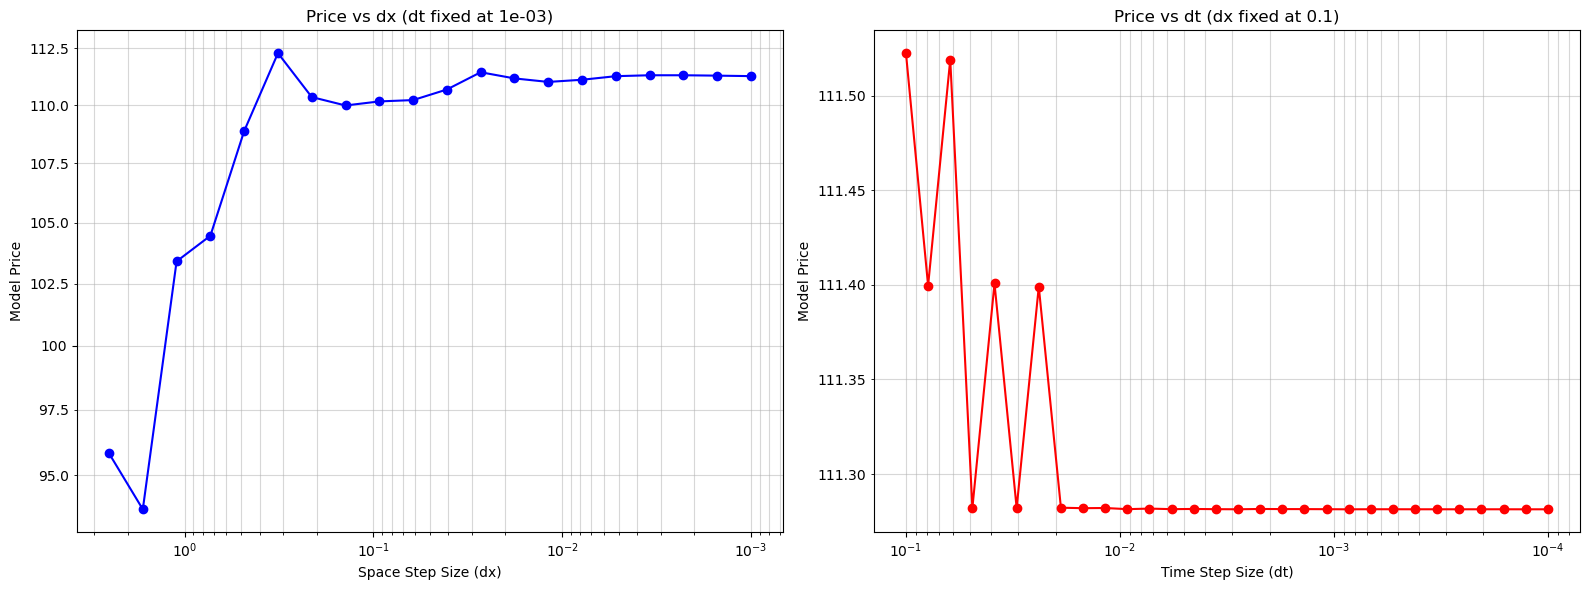

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# 创建可视化图表
plt.figure(figsize=(16, 6))

# dx收敛图（对数坐标，反向）
plt.subplot(1, 2, 1)
plt.loglog(dx_values, prices_dx, 'b-o')
plt.gca().invert_xaxis()  # 反转x轴
plt.title('Price vs dx (dt fixed at %.0e)' % dt_fixed)
plt.xlabel('Space Step Size (dx)')
plt.ylabel('Model Price')
plt.grid(True, which="both", ls="-", alpha=0.5)

# 手动设置y轴为非科学计数法（对数坐标）
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

# dt收敛图（对数坐标，反向）
plt.subplot(1, 2, 2)
plt.loglog(dt_values, prices_dt, 'r-o')
plt.gca().invert_xaxis()  # 反转x轴
plt.title('Price vs dt (dx fixed at %.1f)' % dx_fixed)
plt.xlabel('Time Step Size (dt)')
plt.ylabel('Model Price')
plt.grid(True, which="both", ls="-", alpha=0.5)

# 手动设置y轴为非科学计数法（对数坐标）
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

plt.tight_layout()
plt.show()

# Test convergence under CFL

dx in our test: [0.0031622776601683794, 0.003562247890262444, 0.004012807031942776, 0.004520353656360245, 0.0050920956367733975, 0.005736152510448681, 0.006461670787466969, 0.007278953843983154, 0.008199608244604943, 0.009236708571873866, 0.010404983103657853, 0.011721022975334805, 0.013203517797162948, 0.014873521072935119, 0.01675474918923341, 0.018873918221350976, 0.021261123338996556, 0.02395026619987486, 0.026979536400729993, 0.03039195382313198, 0.03423597957607582, 0.03856620421163472, 0.043444122987293665, 0.04893900918477494, 0.05512889788770675, 0.06210169418915616, 0.0699564215671263, 0.07880462815669913, 0.08877197088985865, 0.1]


100%|██████████| 30/30 [02:43<00:00,  5.45s/it]


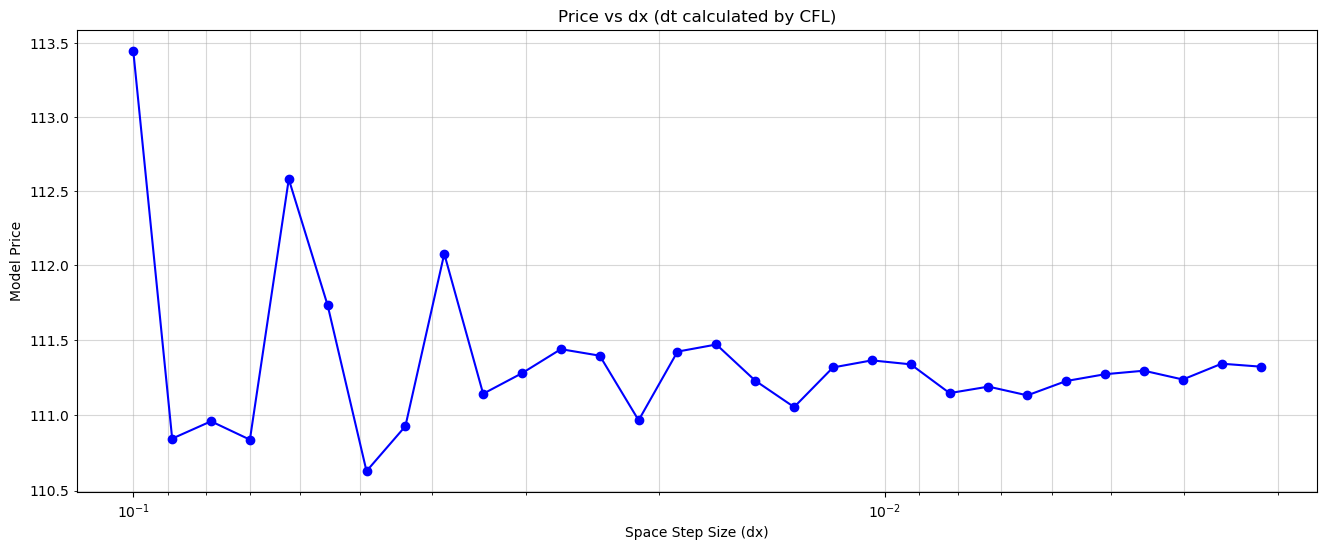

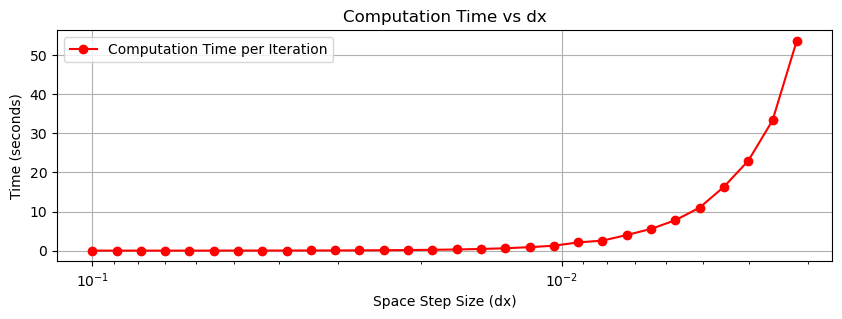

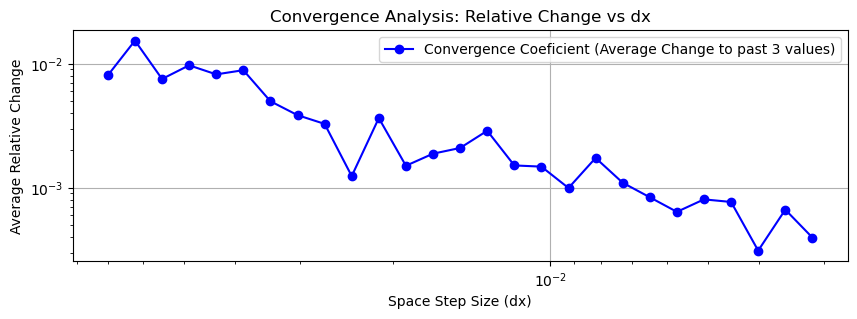

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter

# 生成 dx 值
dx_values = list(np.logspace(-2.5, -1, 30))# + list(np.logspace(-1, 0.4, 20))
prices = []
errors = []
times = []  # 记录计算时间
relative_changes = []  # 记录相对差异

print(f"dx in our test: {dx_values}")

for dx in tqdm(dx_values):
    start_time = time.time()  # 计时开始
    
    dt = 2 * dx**2 / (v / 100)**2  # CFL
    price = crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                   dx, dt, S)
    prices.append(price)
    
    end_time = time.time()  # 计时结束
    times.append(end_time - start_time)  # 记录计算时间

# 计算相对变化
for i in range(len(prices)):
    if i <= len(prices) - 4:  # 确保 i+1, i+2, i+3 存在
        diff1 = abs(prices[i] - prices[i+1]) / prices[i+1]
        diff2 = abs(prices[i] - prices[i+2]) / prices[i+2]
        diff3 = abs(prices[i] - prices[i+3]) / prices[i+3]
        avg_relative_change = (diff1 + diff2 + diff3) / 3
    else:
        avg_relative_change = np.nan  # 后面不足三个点，设为 NaN

    relative_changes.append(avg_relative_change)

# 创建可视化图表
plt.figure(figsize=(10, 3))
# dx收敛图（对数坐标，反向）
plt.loglog(dx_values, prices, 'b-o')
plt.gca().invert_xaxis()  # 反转x轴
plt.title('Price vs dx (dt calculated by CFL)')
plt.xlabel('Space Step Size (dx)')
plt.ylabel('Model Price')
plt.grid(True, which="both", ls="-", alpha=0.5)
# 手动设置y轴为非科学计数法（对数坐标）
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())
plt.show()

# 可视化计算时间
plt.figure(figsize=(10, 3))
plt.plot(dx_values, times, 'ro-', label="Computation Time per Iteration")
plt.gca().invert_xaxis()  # 反转x轴
plt.xscale("log")
plt.xlabel("Space Step Size (dx)")
plt.ylabel("Time (seconds)")
plt.title("Computation Time vs dx")
plt.legend()
plt.grid()
plt.show()

# 可视化相对变化
plt.figure(figsize=(10, 3))
plt.plot(dx_values, relative_changes, 'bo-', label="Convergence Coeficient (Average Change to past 3 values)")
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()  # 反转x轴
plt.xlabel("Space Step Size (dx)")
plt.ylabel("Average Relative Change")
plt.title("Convergence Analysis: Relative Change vs dx")
plt.legend()
plt.grid()
plt.show()

# Surface of dx and dt

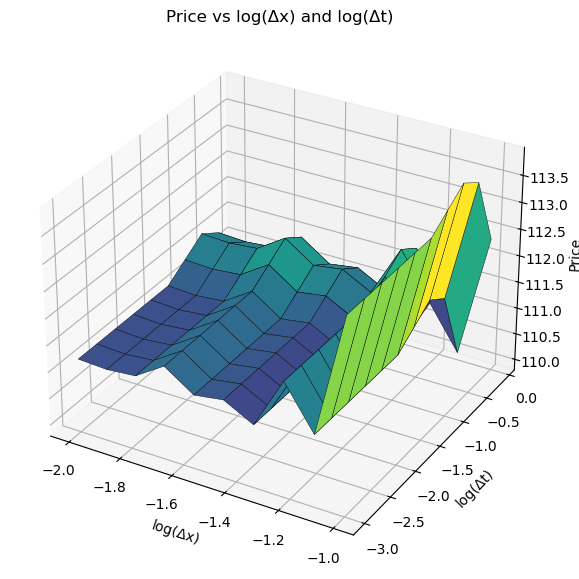

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

dx_vals = np.logspace(-3, -1, 10)  # 从 0.01 到 1
dt_vals = np.logspace(-3, -0.1, 10)  # 从 0.001 到 ~0.3

DX, DT = np.meshgrid(dx_vals, dt_vals)
Price = np.vectorize(crank_nicolson_TF_dxdt)(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                   DX, DT, S)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

log_dx = np.log10(DX)
log_dt = np.log10(DT)

# 绘图
ax.plot_surface(log_dx, log_dt, Price, cmap='viridis', edgecolor='k', linewidth=0.3)

ax.set_xlabel('log(Δx)')
ax.set_ylabel('log(Δt)')
ax.set_zlabel('Price')
ax.set_title('Price vs log(Δx) and log(Δt)')

plt.show()

# Test on every bond (Integrated all code before)

In [2]:
import pandas as pd
'''
Read Data to get asset names
'''
file_path = "CBdata.xlsx"
xls = pd.read_excel(file_path, sheet_name=None, header=None,engine='openpyxl')
Name_df = xls["NaME"]

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import scipy.stats as stats
import warnings
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

from functions import block_thomas_solve
from functions import crank_nicolson_TF_dxdt

from functions import explicit_FD
from functions import find_between

Name_df

,0,1
0,TEVA 0 ¼ 02/01/26 Corp,0.0000
1,LBRDA 3.125 03/31/53 Corp,0.0010
2,CMCSA 2 10/15/29 Corp,0.0276
3,DISH 2 ⅜ 03/15/24 Corp,0.0000
4,DISH 2 ⅜ 08/15/24 Corp,0.0000
...,...,...
80,ATSG 1.125 10/15/24 Corp,0.1817
81,VSH 2.25 06/15/25 Corp,0.0182
82,AY 4 07/15/25 Corp,0.0980
83,LNT 3.875 03/15/26 Corp,0.0396


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
from numpy.linalg import LinAlgError

bonds_converged_points = {}
# 生成 dx 值
dx_values = list(np.logspace(-2.25, -1, 40)) + list(np.logspace(-1, 0.4, 20))
dx_values.reverse()
print(f"dx in our test: {dx_values}")

for i in range(len(Name_df)):
    print(f'------------------- Bond: {sheetname} -------------------')
    try:
        sheetname=Name_df.iloc[i,0].replace("/", " ")
        d=Name_df.iloc[i-1,1] # 股息率
        CB_df=xls[sheetname] # sheetname --> data
        
        # extract parameters
        CR=CB_df.iloc[0,9]     # conversion ratio
        CP=CB_df.iloc[1,9]     # conversion price
        Coupon=CB_df.iloc[2,9]/100
        FCP=pd.to_datetime(CB_df.iloc[4,9]) # first coupon payment
        CFQ=CB_df.iloc[5,9]     # Coupon Frequency
        M=pd.to_datetime(CB_df.iloc[6,9])   # Maturity date
        call_date = CB_df.iloc[0,12]
        call_price = CB_df.iloc[1,12]
        put_date = CB_df.iloc[2,12]
        put_price = CB_df.iloc[3,12]
        
        # Data Processing
        Price_df= CB_df.iloc[9:, 0:2].dropna()
        IVOL_df=CB_df.iloc[9:, 5:7].dropna()
        CDS_df=CB_df.iloc[9:, 7:9].dropna()
        S_df=CB_df.iloc[9:, 9:11].dropna()
        Price_df= Price_df.rename(columns={0: "date", 1: 'bond_price'})
        CDS_df= CDS_df.rename(columns={7: "date", 8: 'CDS'})
        IVOL_df= IVOL_df.rename(columns={5: "date", 6: 'IVOL'})
        S_df= S_df.rename(columns={9: "date", 10: 'S'})
        Price_df['date'] = pd.to_datetime(Price_df['date'])
        IVOL_df['date'] = pd.to_datetime(IVOL_df['date'])
        CDS_df['date'] = pd.to_datetime(CDS_df['date'])
        S_df['date'] = pd.to_datetime(S_df['date'])
        # Merge all data together (CBprice,IV,CDS,StockPrice)
        Price_df = pd.merge(Price_df, IVOL_df, on="date", how='inner')
        Price_df = pd.merge(Price_df, CDS_df, on="date", how='inner')
        Price_df = pd.merge(Price_df, S_df, on="date", how='inner')
        
        # Interplotation of Risk Free Rates in Different Periods
        r_df=xls['R'].rename(columns={0: "date"}).iloc[1:,:]
        r_df['date'] = pd.to_datetime(r_df['date']) 
        Price_df = pd.merge(Price_df, r_df, on="date", how='inner')
        Price_df =Price_df .dropna()
        if len(Price_df)<2:
            print(i)
        
        # rate interplotation and simulate price
        rlist=[1/12,1/6,1/4,1/2,1,2,3,5,7,10,20,30]
        SimulatePrice=[]
        
        j = 0
        date1,v,CDS,S=Price_df.iloc[j,0],Price_df.iloc[j,2],Price_df.iloc[j,3],Price_df.iloc[j,4]
        T = (M - date1).days
        CPT=(FCP - date1).days%(360/CFQ)/T
        Year=T/360
        rlow,rhigh=find_between(rlist,Year)
        r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
    
    
    
        prices = []
        
        for dx in tqdm(dx_values):
            start_time = time.time()  # 计时开始
            
            dt = 2 * dx**2 / (v / 100)**2  # CFL
            price = crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                           dx, dt, S)
            prices.append(price)
            
            end_time = time.time()  # 计时结束
            computation_time = end_time-start_time
            if len(prices) > 3:
                convergence_coefficient = (abs(price-prices[-1])+abs(price-prices[-2])+abs(price-prices[-3]))/3/price
                if convergence_coefficient < 0.001:
                    print("Convergence point found!")
                    print(f"dt:{dt}, dx:{dx}")
                    print(f"time:{computation_time}")
                    print(f"convergence_coefficient:{convergence_coefficient}")
                    print(f"dt:{dt}, dx:{dx}")
                    print(f"time:{computation_time}")
        
                    params_dict = {
                        "TTM(Year)": Year,
                        "IV": v/100,  # 假设变量名是 v_100
                        "r": r,
                        "d": d,
                        "CDS/10000": CDS/10000,  # 假设变量名是 CDS_10000
                        "Conversion Price": CP,
                        "Coupon": Coupon,
                        "Coupon Frequency": CFQ,
                        "CPT": CPT,
                        "dx": dx,
                        "dt": dt,
                        "S": S,
                        "computation_time": computation_time
                    }
                    print("Convergence point found!")
                    break
                
        bond_name = Name_df.iloc[i,0]
        bonds_converged_points[bond_name] = params_dict
        
    except:
        print('Error occured')
        continue

results = pd.DataFrame(bonds_converged_points)
results

dx in our test: [2.51188643150958, 2.1199020238496082, 1.789087489923219, 1.5098971606184193, 1.2742749857031335, 1.0754220761125606, 0.907600521681814, 0.7659678234751834, 0.646437163249006, 0.5455594781168519, 0.4604239376758781, 0.38857395185709753, 0.32793628590208806, 0.2767612370754227, 0.23357214690901226, 0.19712279215176962, 0.16636142493842218, 0.1404004245548316, 0.11849068510006666, 0.1, 0.1, 0.0928856699709695, 0.08627747685955867, 0.0801394124150493, 0.07443803013251689, 0.06914226300178047, 0.06422325422229357, 0.05965419996153637, 0.05541020330009492, 0.05146813856756942, 0.047806525330073804, 0.04440541134268032, 0.04124626382901352, 0.03831186849557287, 0.035586235730509654, 0.03305451347573245, 0.0307029062975785, 0.028518600215064777, 0.02648969287610527, 0.024605128701222573, 0.022854638641349907, 0.021228684221461944, 0.01971840556512642, 0.01831557311676062, 0.017012542798525893, 0.015802214357508698, 0.01467799267622069, 0.013633751835597433, 0.01266380173467403

 77%|███████▋  | 46/60 [00:21<00:06,  2.17it/s] 
/tmp/ipykernel_2175/1074203131.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
/tmp/ipykernel_2175/1074203131.py:69: RuntimeWarning: invalid value encountered in scalar add
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100


Convergence point found!
dt:0.0017736599674587166, dx:0.01467799267622069
time:4.278296709060669
convergence_coefficient:0.0009959478755956898
dt:0.0017736599674587166, dx:0.01467799267622069
time:4.278296709060669
Convergence point found!
------------------- Bond: TEVA 0 ¼ 02 01 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: LBRDA 3.125 03 31 53 Corp -------------------


 67%|██████▋   | 40/60 [00:01<00:00, 25.48it/s] 


Convergence point found!
dt:0.027836609800538266, dx:0.022854638641349907
time:0.3064920902252197
convergence_coefficient:7.868593615694665e-05
dt:0.027836609800538266, dx:0.022854638641349907
time:0.3064920902252197
Convergence point found!
------------------- Bond: CMCSA 2 10 15 29 Corp -------------------


 18%|█▊        | 11/60 [00:00<00:00, 26684.41it/s]


Convergence point found!
dt:3.2920598099174985, dx:0.38857395185709753
time:4.4345855712890625e-05
convergence_coefficient:0.00046600921671650415
dt:3.2920598099174985, dx:0.38857395185709753
time:4.4345855712890625e-05
Convergence point found!
------------------- Bond: DISH 2 ⅜ 03 15 24 Corp -------------------


 47%|████▋     | 28/60 [00:00<00:00, 141.55it/s]


Convergence point found!
dt:0.06694217759077227, dx:0.05541020330009492
time:0.026829242706298828
convergence_coefficient:0.0008352200657294848
dt:0.06694217759077227, dx:0.05541020330009492
time:0.026829242706298828
Convergence point found!
------------------- Bond: DISH 2 ⅜ 08 15 24 Corp -------------------


 58%|█████▊    | 35/60 [00:00<00:00, 73.23it/s] 


Convergence point found!
dt:0.025410286907147937, dx:0.03305451347573245
time:0.09707403182983398
convergence_coefficient:0.0006864427186514892
dt:0.025410286907147937, dx:0.03305451347573245
time:0.09707403182983398
Convergence point found!
------------------- Bond: SRENVX 3 ¼ 06 13 24 Corp -------------------


 53%|█████▎    | 32/60 [00:00<00:00, 329.40it/s]
/tmp/ipykernel_2175/1074203131.py:69: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100


Convergence point found!
dt:0.06830579423013894, dx:0.04124626382901352
time:0.012936830520629883
convergence_coefficient:0.000635702343301305
dt:0.06830579423013894, dx:0.04124626382901352
time:0.012936830520629883
Convergence point found!
------------------- Bond: FE 4 05 01 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: JPM 0 ½ 06 15 27 Corp -------------------


 57%|█████▋    | 34/60 [00:00<00:00, 327.66it/s]


Convergence point found!
dt:0.09300926153493615, dx:0.035586235730509654
time:0.05431962013244629
convergence_coefficient:0.0007725657020334099
dt:0.09300926153493615, dx:0.035586235730509654
time:0.05431962013244629
Convergence point found!
------------------- Bond: MS 2 ½ 11 06 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: NCLH 5 ⅜ 08 01 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: NCLH 6 05 15 24 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: PCG 4.25 12 01 27 Corp -------------------


 28%|██▊       | 17/60 [00:00<00:00, 2120.79it/s]


Convergence point found!
dt:0.08180410502823661, dx:0.1404004245548316
time:0.0032401084899902344
convergence_coefficient:0.0008569245474703917
dt:0.08180410502823661, dx:0.1404004245548316
time:0.0032401084899902344
Convergence point found!
------------------- Bond: RCL 6 08 15 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: SABHLD 4 04 15 25 Corp -------------------


 33%|███▎      | 20/60 [00:00<00:00, 251.00it/s]


Convergence point found!
dt:0.04710595821272698, dx:0.1
time:0.01227569580078125
convergence_coefficient:2.825945364132652e-05
dt:0.04710595821272698, dx:0.1
time:0.01227569580078125
Convergence point found!
------------------- Bond: LUV 1 ¼ 05 01 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: TSLA 2 05 15 24 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: RIG 4 12 15 25 Corp -------------------


 22%|██▏       | 13/60 [00:00<00:00, 31942.56it/s]

Convergence point found!
dt:2.249482657675977, dx:0.2767612370754227
time:4.482269287109375e-05
convergence_coefficient:0.0008233861752570848
dt:2.249482657675977, dx:0.2767612370754227
time:4.482269287109375e-05
Convergence point found!
------------------- Bond: VTR 3 ¾ 06 01 26 Corp -------------------



 40%|████      | 24/60 [00:00<00:00, 1622.29it/s]


Convergence point found!
dt:0.25217648314070656, dx:0.07443803013251689
time:0.0034215450286865234
convergence_coefficient:0.0004736959478313351
dt:0.25217648314070656, dx:0.07443803013251689
time:0.0034215450286865234
Convergence point found!
------------------- Bond: WFC 0 ¼ 11 01 24 Corp -------------------


 63%|██████▎   | 38/60 [00:00<00:00, 263.11it/s]


Convergence point found!
dt:0.057719015347753914, dx:0.02648969287610527
time:0.04898691177368164
convergence_coefficient:0.0006029143869508639
dt:0.057719015347753914, dx:0.02648969287610527
time:0.04898691177368164
Convergence point found!
------------------- Bond: SO 3.875 12 15 25 Corp -------------------


 50%|█████     | 30/60 [00:00<00:00, 293.86it/s]


Convergence point found!
dt:0.05900778077092611, dx:0.047806525330073804
time:0.014987945556640625
convergence_coefficient:0.00037930565374444717
dt:0.05900778077092611, dx:0.047806525330073804
time:0.014987945556640625
Convergence point found!
------------------- Bond: NEE 3 03 01 27 Corp -------------------


 47%|████▋     | 28/60 [00:00<00:00, 138.86it/s]


Convergence point found!
dt:0.06694217759077227, dx:0.05541020330009492
time:0.02718830108642578
convergence_coefficient:0.0003877600391209616
dt:0.06694217759077227, dx:0.05541020330009492
time:0.02718830108642578
Convergence point found!
------------------- Bond: DISH 3.375 08 15 26 Corp -------------------


  5%|▌         | 3/60 [00:00<00:00, 14961.85it/s]


Convergence point found!
dt:134.05420410554018, dx:1.5098971606184193
time:1.239776611328125e-05
convergence_coefficient:0.0
dt:134.05420410554018, dx:1.5098971606184193
time:1.239776611328125e-05
Convergence point found!
------------------- Bond: BACR 1 02 16 29 Corp -------------------
23
Error occured
------------------- Bond: CDMO 7 03 01 29 Corp -------------------


 33%|███▎      | 20/60 [00:00<00:00, 409.27it/s]


Convergence point found!
dt:0.04710595821272698, dx:0.1
time:0.012709379196166992
convergence_coefficient:2.825945364132652e-05
dt:0.04710595821272698, dx:0.1
time:0.012709379196166992
Convergence point found!
------------------- Bond: LUV 1.25 05 01 25 Corp -------------------


 28%|██▊       | 17/60 [00:00<00:00, 2343.34it/s]

Convergence point found!
dt:0.8522733284439281, dx:0.1404004245548316
time:0.0029714107513427734
convergence_coefficient:0.0005961784107937723
dt:0.8522733284439281, dx:0.1404004245548316
time:0.0029714107513427734
Convergence point found!
------------------- Bond: NRG 2.75 06 01 48 Corp -------------------



 35%|███▌      | 21/60 [00:00<00:00, 2026.05it/s]

Convergence point found!
dt:0.2006529116574328, dx:0.0928856699709695
time:0.002578258514404297
convergence_coefficient:0.00039636373595833654
dt:0.2006529116574328, dx:0.0928856699709695
time:0.002578258514404297
Convergence point found!


------------------- Bond: SRENVX 3.25 06 13 24 Corp -------------------


 28%|██▊       | 17/60 [00:00<00:00, 335.32it/s]


Convergence point found!
dt:0.09449541101736651, dx:0.1404004245548316
time:0.0057637691497802734
convergence_coefficient:0.0002777777777777427
dt:0.09449541101736651, dx:0.1404004245548316
time:0.0057637691497802734
Convergence point found!
------------------- Bond: LI 0.25 05 01 28 Corp -------------------
28
Error occured
------------------- Bond: SABHLD 7.32 08 01 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: MDRX 0.875 01 01 27 Corp -------------------


 60%|██████    | 36/60 [00:06<00:04,  5.95it/s] 


Convergence point found!
dt:0.0033710725887630306, dx:0.0307029062975785
time:1.3640027046203613
convergence_coefficient:0.0007384226223823196
dt:0.0033710725887630306, dx:0.0307029062975785
time:1.3640027046203613
Convergence point found!
------------------- Bond: IHFLIN 4.5 09 28 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: PRCH 6.75 10 01 28 Corp -------------------


  5%|▌         | 3/60 [00:00<00:00, 19878.22it/s]


Convergence point found!
dt:13.08352367532232, dx:1.5098971606184193
time:1.5020370483398438e-05
convergence_coefficient:0.0
dt:13.08352367532232, dx:1.5098971606184193
time:1.5020370483398438e-05
Convergence point found!
------------------- Bond: BKNG 0.75 05 01 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: ABR 7.5 08 01 25 Corp -------------------


 53%|█████▎    | 32/60 [00:00<00:00, 67.90it/s] 


Convergence point found!
dt:0.02346935491053934, dx:0.04124626382901352
time:0.09053301811218262
convergence_coefficient:0.0005569711503145272
dt:0.02346935491053934, dx:0.04124626382901352
time:0.09053301811218262
Convergence point found!
------------------- Bond: ZTO 1.5 09 01 27 Corp -------------------


 97%|█████████▋| 58/60 [06:33<00:13,  6.79s/it]

Convergence point found!
dt:0.00033395601333056435, dx:0.006054123584037268
time:77.80968880653381
convergence_coefficient:0.0007989230952907935
dt:0.00033395601333056435, dx:0.006054123584037268
time:77.80968880653381
Convergence point found!
------------------- Bond: AYX 1 08 01 26 Corp -------------------



  0%|          | 0/60 [00:00<?, ?it/s]

Error occured
------------------- Bond: IRWD 0.75 06 15 24 Corp -------------------



 63%|██████▎   | 38/60 [00:02<00:01, 14.59it/s] 


Convergence point found!
dt:0.006584265932736647, dx:0.02648969287610527
time:0.5186567306518555
convergence_coefficient:0.0006090217727756943
dt:0.006584265932736647, dx:0.02648969287610527
time:0.5186567306518555
Convergence point found!
------------------- Bond: TWO 6.25 01 15 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]
/tmp/ipykernel_2175/1074203131.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
/tmp/ipykernel_2175/1074203131.py:69: RuntimeWarning: invalid value encountered in scalar add
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100


Error occured
------------------- Bond: IQ 4 12 15 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: LMCA 2.75 12 01 49 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: IRWD 1.5 06 15 26 Corp -------------------


 83%|████████▎ | 50/60 [00:09<00:01,  5.43it/s] 


Convergence point found!
dt:0.0056472792055385634, dx:0.01092600861117378
time:1.8028149604797363
convergence_coefficient:0.0003623084022577705
dt:0.0056472792055385634, dx:0.01092600861117378
time:1.8028149604797363
Convergence point found!
------------------- Bond: AKAM 0.125 05 01 25 Corp -------------------


 83%|████████▎ | 50/60 [00:04<00:00, 10.44it/s] 


Convergence point found!
dt:0.006266686145224358, dx:0.01092600861117378
time:0.9391453266143799
convergence_coefficient:0.00027703302035067063
dt:0.006266686145224358, dx:0.01092600861117378
time:0.9391453266143799
Convergence point found!
------------------- Bond: DUK 4.125 04 15 26 Corp -------------------


 53%|█████▎    | 32/60 [00:01<00:01, 18.98it/s] 


Convergence point found!
dt:0.012301550475875413, dx:0.04124626382901352
time:0.3268108367919922
convergence_coefficient:0.0009647127403037156
dt:0.012301550475875413, dx:0.04124626382901352
time:0.3268108367919922
Convergence point found!
------------------- Bond: EXAS 0.375 03 01 28 Corp -------------------


 57%|█████▋    | 34/60 [00:00<00:00, 119.34it/s]


Convergence point found!
dt:0.040676641152165155, dx:0.035586235730509654
time:0.03572273254394531
convergence_coefficient:0.0008979227027384102
dt:0.040676641152165155, dx:0.035586235730509654
time:0.03572273254394531
Convergence point found!
------------------- Bond: EVRG 4.5 12 15 27 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: CNK 4.5 08 15 25 Corp -------------------


 83%|████████▎ | 50/60 [03:45<00:45,  4.51s/it] 


Convergence point found!
dt:0.00026600005580833724, dx:0.01092600861117378
time:46.4014151096344
convergence_coefficient:0.00038831815858480183
dt:0.00026600005580833724, dx:0.01092600861117378
time:46.4014151096344
Convergence point found!
------------------- Bond: BBIO 2.5 03 15 27 Corp -------------------


 62%|██████▏   | 37/60 [00:02<00:01, 13.64it/s] 


Convergence point found!
dt:0.007410424964045595, dx:0.028518600215064777
time:0.5236184597015381
convergence_coefficient:0.00026496517489273455
dt:0.007410424964045595, dx:0.028518600215064777
time:0.5236184597015381
Convergence point found!
------------------- Bond: AYX 0.5 08 01 24 Corp -------------------


 87%|████████▋ | 52/60 [00:07<00:01,  6.60it/s] 


Convergence point found!
dt:0.004939280045388555, dx:0.009426684551178854
time:1.582947015762329
convergence_coefficient:0.0008142699937953108
dt:0.004939280045388555, dx:0.009426684551178854
time:1.582947015762329
Convergence point found!
------------------- Bond: AWK 3.625 06 15 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: STWD 6.75 07 15 27 Corp -------------------


 47%|████▋     | 28/60 [00:00<00:00, 59.60it/s] 


Convergence point found!
dt:0.0212089423389943, dx:0.05541020330009492
time:0.09906578063964844
convergence_coefficient:0.00038330567971484546
dt:0.0212089423389943, dx:0.05541020330009492
time:0.09906578063964844
Convergence point found!
------------------- Bond: HTHT 3 05 01 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: WB 1.375 12 01 30 Corp -------------------


 83%|████████▎ | 50/60 [01:03<00:12,  1.28s/it] 


Convergence point found!
dt:0.0008475140035196253, dx:0.01092600861117378
time:12.746683359146118
convergence_coefficient:0.000990006813236916
dt:0.0008475140035196253, dx:0.01092600861117378
time:12.746683359146118
Convergence point found!
------------------- Bond: JPM 0.5 06 15 27 Corp -------------------


 60%|██████    | 36/60 [00:00<00:00, 59.34it/s] 


Convergence point found!
dt:0.044593869391338276, dx:0.0307029062975785
time:0.14875221252441406
convergence_coefficient:0.0005876261278462381
dt:0.044593869391338276, dx:0.0307029062975785
time:0.14875221252441406
Convergence point found!
------------------- Bond: AKAM 0.375 09 01 27 Corp -------------------


 45%|████▌     | 27/60 [00:00<00:00, 237.25it/s]


Convergence point found!
dt:0.06612420702062095, dx:0.05965419996153637
time:0.016649246215820312
convergence_coefficient:0.0006987822135428496
dt:0.06612420702062095, dx:0.05965419996153637
time:0.016649246215820312
Convergence point found!
------------------- Bond: BMRN 0.599 08 01 24 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: PMT 5.5 11 01 24 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]

Error occured
------------------- Bond: GDSHDG 4.5 01 31 30 Corp -------------------



  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: BILI 1.375 04 01 26 Corp -------------------


 38%|███▊      | 23/60 [00:00<00:00, 237.70it/s]

Convergence point found!
dt:0.08261016776188351, dx:0.0801394124150493
time:0.014504194259643555
convergence_coefficient:0.00019680974259821482
dt:0.08261016776188351, dx:0.0801394124150493
time:0.014504194259643555
Convergence point found!
------------------- Bond: ETSY 0.125 10 01 26 Corp -------------------



 60%|██████    | 36/60 [00:00<00:00, 55.00it/s] 


Convergence point found!
dt:0.03976569193901842, dx:0.0307029062975785
time:0.14769911766052246
convergence_coefficient:0.000337598607147364
dt:0.03976569193901842, dx:0.0307029062975785
time:0.14769911766052246
Convergence point found!
------------------- Bond: ZD 1.75 11 01 26 Corp -------------------


 43%|████▎     | 26/60 [00:00<00:00, 284.94it/s]


Convergence point found!
dt:0.06587859083536095, dx:0.06422325422229357
time:0.04531288146972656
convergence_coefficient:0.0008793897828071876
dt:0.06587859083536095, dx:0.06422325422229357
time:0.04531288146972656
Convergence point found!
------------------- Bond: NEP 2.5 06 15 26 Corp -------------------


 95%|█████████▌| 57/60 [01:14<00:03,  1.30s/it] 


Convergence point found!
dt:0.001269655549398695, dx:0.006517823024724289
time:14.70369029045105
convergence_coefficient:0.0008565300893438219
dt:0.001269655549398695, dx:0.006517823024724289
time:14.70369029045105
Convergence point found!
------------------- Bond: AKAM 1.125 02 15 29 Corp -------------------


 90%|█████████ | 54/60 [04:41<00:31,  5.22s/it] 


Convergence point found!
dt:0.00020121764365939307, dx:0.008133105582266927
time:55.507781982421875
convergence_coefficient:0.000805551236841956
dt:0.00020121764365939307, dx:0.008133105582266927
time:55.507781982421875
Convergence point found!
------------------- Bond: IHFLIN 4.5 03 04 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: CHRS 1.5 04 15 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: RWT 5.75 10 01 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: PSEC 6.375 03 01 25 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: OPK 3.75 01 15 29 Corp -------------------


 22%|██▏       | 13/60 [00:00<00:00, 32494.61it/s]


Convergence point found!
dt:2.249482657675977, dx:0.2767612370754227
time:4.506111145019531e-05
convergence_coefficient:0.0008233861752570848
dt:2.249482657675977, dx:0.2767612370754227
time:4.506111145019531e-05
Convergence point found!
------------------- Bond: VTR 3.75 06 01 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: PMT 5.5 03 15 26 Corp -------------------


 53%|█████▎    | 32/60 [00:01<00:01, 25.40it/s] 


Convergence point found!
dt:0.008282351026108546, dx:0.04124626382901352
time:0.23706841468811035
convergence_coefficient:0.0009659371483285526
dt:0.008282351026108546, dx:0.04124626382901352
time:0.23706841468811035
Convergence point found!
------------------- Bond: QGEN 1 11 13 24 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: GEO 6.5 02 23 26 Corp -------------------


 52%|█████▏    | 31/60 [00:00<00:00, 62.77it/s] 


Convergence point found!
dt:0.026604801751352058, dx:0.04440541134268032
time:0.10050797462463379
convergence_coefficient:0.000956080962730413
dt:0.026604801751352058, dx:0.04440541134268032
time:0.10050797462463379
Convergence point found!
------------------- Bond: PRFT 0.125 11 15 26 Corp -------------------


 63%|██████▎   | 38/60 [00:00<00:00, 78.22it/s] 


Convergence point found!
dt:0.03378768485523757, dx:0.02648969287610527
time:0.09867501258850098
convergence_coefficient:0.0008623271596124064
dt:0.03378768485523757, dx:0.02648969287610527
time:0.09867501258850098
Convergence point found!
------------------- Bond: KAMN 3.25 05 01 24 Corp -------------------


 45%|████▌     | 27/60 [00:00<00:00, 322.84it/s]


Convergence point found!
dt:0.0939182748627569, dx:0.05965419996153637
time:0.010957479476928711
convergence_coefficient:0.0001403189006541043
dt:0.0939182748627569, dx:0.05965419996153637
time:0.010957479476928711
Convergence point found!
------------------- Bond: GTLS 1 11 15 24 Corp -------------------


 40%|████      | 24/60 [00:00<00:00, 210.43it/s]


Convergence point found!
dt:0.06571035036378847, dx:0.07443803013251689
time:0.017444133758544922
convergence_coefficient:0.0006511915334358764
dt:0.06571035036378847, dx:0.07443803013251689
time:0.017444133758544922
Convergence point found!
------------------- Bond: YY 1.375 06 15 26 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: NCLH 5.375 08 01 25 Corp -------------------


  5%|▌         | 3/60 [00:00<00:00, 18342.44it/s]

Convergence point found!
dt:36.55421372591797, dx:1.5098971606184193
time:7.3909759521484375e-06
convergence_coefficient:0.00042447728862787473
dt:36.55421372591797, dx:1.5098971606184193
time:7.3909759521484375e-06
Convergence point found!
------------------- Bond: WGO 1.5 04 01 25 Corp -------------------



  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: RWT 5.625 07 15 24 Corp -------------------


 48%|████▊     | 29/60 [00:00<00:00, 98.89it/s] 


Convergence point found!
dt:0.032866802370050074, dx:0.05146813856756942
time:0.03773665428161621
convergence_coefficient:0.0009793303890010296
dt:0.032866802370050074, dx:0.05146813856756942
time:0.03773665428161621
Convergence point found!
------------------- Bond: ENOV 3.875 10 15 28 Corp -------------------


  0%|          | 0/60 [00:00<?, ?it/s]


Error occured
------------------- Bond: MITT 6.75 09 15 24 Corp -------------------


 63%|██████▎   | 38/60 [00:01<00:00, 33.75it/s] 


Convergence point found!
dt:0.013416918506391661, dx:0.02648969287610527
time:0.2176375389099121
convergence_coefficient:0.00023974031272827517
dt:0.013416918506391661, dx:0.02648969287610527
time:0.2176375389099121
Convergence point found!
------------------- Bond: ATSG 1.125 10 15 24 Corp -------------------


 55%|█████▌    | 33/60 [00:00<00:00, 90.78it/s] 


Convergence point found!
dt:0.03507589830193992, dx:0.03831186849557287
time:0.0785684585571289
convergence_coefficient:0.0009172145128604062
dt:0.03507589830193992, dx:0.03831186849557287
time:0.0785684585571289
Convergence point found!
------------------- Bond: VSH 2.25 06 15 25 Corp -------------------


 48%|████▊     | 29/60 [00:00<00:00, 101.47it/s]


Convergence point found!
dt:0.029021129742044727, dx:0.05146813856756942
time:0.07473206520080566
convergence_coefficient:0.0009142784929754916
dt:0.029021129742044727, dx:0.05146813856756942
time:0.07473206520080566
Convergence point found!
------------------- Bond: AY 4 07 15 25 Corp -------------------


 22%|██▏       | 13/60 [00:00<00:00, 33207.04it/s]


Convergence point found!
dt:2.773186889320802, dx:0.2767612370754227
time:4.673004150390625e-05
convergence_coefficient:0.0003531600453541325
dt:2.773186889320802, dx:0.2767612370754227
time:4.673004150390625e-05
Convergence point found!
------------------- Bond: LNT 3.875 03 15 26 Corp -------------------


 17%|█▋        | 10/60 [00:00<00:00, 35275.90it/s]

Convergence point found!
dt:10.125777970144068, dx:0.4604239376758781
time:2.4080276489257812e-05
convergence_coefficient:0.000764815866202831
dt:10.125777970144068, dx:0.4604239376758781
time:2.4080276489257812e-05
Convergence point found!


,TEVA 0 ¼ 02/01/26 Corp,CMCSA 2 10/15/29 Corp,DISH 2 ⅜ 03/15/24 Corp,DISH 2 ⅜ 08/15/24 Corp,SRENVX 3 ¼ 06/13/24 Corp,FE 4 05/01/26 Corp,MS 2 ½ 11/06/26 Corp,RCL 6 08/15/25 Corp,LUV 1 ¼ 05/01/25 Corp,VTR 3 ¾ 06/01/26 Corp,...,KAMN 3.25 05/01/24 Corp,GTLS 1 11/15/24 Corp,YY 1.375 06/15/26 Corp,WGO 1.5 04/01/25 Corp,ENOV 3.875 10/15/28 Corp,ATSG 1.125 10/15/24 Corp,VSH 2.25 06/15/25 Corp,AY 4 07/15/25 Corp,LNT 3.875 03/15/26 Corp,CNP 4.25 08/15/26 Corp
TTM(Year),6.172222,9.927778,4.261111,6.713889,3.761111,3.041667,3.044444,3.077778,5.077778,3.022222,...,4.391667,4.941667,6.544444,5.322222,5.061111,4.855556,5.530556,5.066667,3.086111,3.080556
IV,0.492886,0.193723,0.302869,0.302869,0.293252,0.223188,0.165019,0.694218,0.651594,0.260963,...,0.203804,0.275284,0.410670,0.353178,0.401490,0.323419,0.289297,0.427264,0.235034,0.204625
r,0.017197,0.017922,0.016196,0.016872,0.002219,0.034644,0.046027,0.028670,0.005138,0.039234,...,0.016143,0.015923,0.016973,0.017707,0.049279,0.015958,0.017582,0.004640,0.041942,0.042521
d,0.028700,0.001000,0.027600,0.000000,0.000000,0.000000,0.022300,0.002400,0.000000,0.000000,...,0.000000,0.017500,0.010000,0.000000,0.103600,0.033200,0.181700,0.018200,0.098000,0.039600
CDS/10000,0.013240,0.004910,0.011920,0.011920,0.005070,0.008830,0.017040,0.057160,0.014880,0.014140,...,0.003050,0.009010,0.009900,0.011680,0.007630,0.010480,0.007390,0.009400,0.008960,0.006060
Conversion Price,39.784052,71.520000,234.318251,185.752763,94.161001,46.812096,97.195993,50.105974,37.426831,54.806533,...,65.262650,58.725079,83.167691,62.530093,58.317879,31.900471,31.106521,34.355997,64.324815,36.862554
Coupon,0.002500,0.020000,0.023750,0.033750,0.032500,0.040000,0.025000,0.060000,0.012500,0.037500,...,0.032500,0.010000,0.013750,0.015000,0.038750,0.011250,0.022500,0.040000,0.038750,0.042500
Coupon Frequency,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
CPT,0.062106,0.024622,0.039765,0.011998,0.048006,0.002740,0.001825,0.014440,0.003282,0.160846,...,0.068311,0.069140,0.068761,0.046973,0.097695,0.053204,0.078855,0.001096,0.017102,0.015329
dx,0.014678,0.022855,0.388574,0.055410,0.033055,0.041246,0.035586,0.140400,0.100000,0.276761,...,0.026490,0.059654,0.074438,1.509897,0.051468,0.026490,0.038312,0.051468,0.276761,0.460424


In [11]:
results = pd.DataFrame(bonds_converged_points).T
results.to_excel('(bonds_converged_points.xlsx')
results

,TTM(Year),IV,r,d,CDS/10000,Conversion Price,Coupon,Coupon Frequency,CPT,dx,dt,S,computation_time
TEVA 0 ¼ 02/01/26 Corp,6.172222,0.492886,0.017197,0.0287,0.01324,39.784052,0.00250,2.0,0.062106,0.014678,0.001774,9.5600,4.278297
CMCSA 2 10/15/29 Corp,9.927778,0.193723,0.017922,0.0010,0.00491,71.520000,0.02000,4.0,0.024622,0.022855,0.027837,45.3700,0.306492
DISH 2 ⅜ 03/15/24 Corp,4.261111,0.302869,0.016196,0.0276,0.01192,234.318251,0.02375,2.0,0.039765,0.388574,3.292060,43.2100,0.000044
DISH 2 ⅜ 08/15/24 Corp,6.713889,0.302869,0.016872,0.0000,0.01192,185.752763,0.03375,2.0,0.011998,0.055410,0.066942,43.2100,0.026829
SRENVX 3 ¼ 06/13/24 Corp,3.761111,0.293252,0.002219,0.0000,0.00507,94.161001,0.03250,2.0,0.048006,0.033055,0.025410,69.7600,0.097074
FE 4 05/01/26 Corp,3.041667,0.223188,0.034644,0.0000,0.00883,46.812096,0.04000,2.0,0.002740,0.041246,0.068306,38.7500,0.012937
MS 2 ½ 11/06/26 Corp,3.044444,0.165019,0.046027,0.0223,0.01704,97.195993,0.02500,2.0,0.001825,0.035586,0.093009,82.4000,0.054320
RCL 6 08/15/25 Corp,3.077778,0.694218,0.028670,0.0024,0.05716,50.105974,0.06000,2.0,0.014440,0.140400,0.081804,38.8400,0.003240
LUV 1 ¼ 05/01/25 Corp,5.077778,0.651594,0.005138,0.0000,0.01488,37.426831,0.01250,2.0,0.003282,0.100000,0.047106,30.9700,0.012276
VTR 3 ¾ 06/01/26 Corp,3.022222,0.260963,0.039234,0.0000,0.01414,54.806533,0.03750,2.0,0.160846,0.276761,2.249483,45.7200,0.000045


In [13]:
len(bonds_converged_points)

53

## Simulated Params

In [3]:
import numpy as np

def generate_uniform_samples(param_ranges, num_samples):
    """
    在参数空间内生成均匀分布的随机点
    
    参数:
    param_ranges: 字典，定义每个参数的范围和类型
        - 连续参数: (min, max)
        - 离散参数: [value1, value2, ...]
        - 整数参数: (min, max, 'int')
    num_samples: 要生成的样本数量
    
    返回:
    包含所有参数组合的字典列表
    """
    samples = []
    for _ in range(num_samples):
        sample = {}
        for param, spec in param_ranges.items():
            # 处理连续参数
            if isinstance(spec, tuple) and len(spec) == 2:
                sample[param] = np.random.uniform(spec[0], spec[1])
            
            # 处理整数参数
            elif isinstance(spec, tuple) and len(spec) == 3 and spec[2] == 'int':
                sample[param] = np.random.randint(spec[0], spec[1] + 1)
            
            # 处理离散参数
            elif isinstance(spec, list):
                sample[param] = np.random.choice(spec)
        
        samples.append(sample)
    return samples

param_ranges = {
    'Year': (1, 30),   # 整数参数
    'v': (10, 200),               # 连续参数
    'd': (0.0, 0.2),              # 连续参数
    'CDS': (10, 1000),           # 连续参数
    'Moneyness': (0.1,1.5),
    'Coupon': (0.0, 0.1),       # 连续参数
    'CPT': (0, 1),                # 连续参数
}

# 生成100个均匀分布的样本点
samples = generate_uniform_samples(param_ranges, num_samples=100)

# 打印前5个样本
for i, sample in enumerate(samples[:5]):
    print(f"Sample {i+1}: {sample}")

Sample 1: {'Year': 22.543859698856313, 'v': 97.90891337092748, 'd': 0.02702915609802863, 'CDS': 933.2902025642894, 'Moneyness': 0.5385494686858932, 'Coupon': 0.020185261399068177, 'CPT': 0.6580676531486265}
Sample 2: {'Year': 22.205073028580788, 'v': 169.37415984261665, 'd': 0.03522467169037926, 'CDS': 88.0840532846038, 'Moneyness': 1.2480276480273755, 'Coupon': 0.09839963255991002, 'CPT': 0.5130702226294991}
Sample 3: {'Year': 26.992832449682716, 'v': 38.83295944094408, 'd': 0.11557745384933649, 'CDS': 721.2105406189868, 'Moneyness': 1.3568268757714885, 'Coupon': 0.03745152842493952, 'CPT': 0.8971950490997603}
Sample 4: {'Year': 2.643458528248315, 'v': 26.389123881647095, 'd': 0.05267028539796388, 'CDS': 140.60148653939402, 'Moneyness': 0.43158529497648646, 'Coupon': 0.0360317415422986, 'CPT': 0.17797084656365736}
Sample 5: {'Year': 18.648311169874695, 'v': 34.28020975358615, 'd': 0.06513918054996706, 'CDS': 954.2221006314346, 'Moneyness': 0.38158301946021966, 'Coupon': 0.060499665219

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from matplotlib.ticker import ScalarFormatter
from numpy.linalg import LinAlgError

bonds_converged_points = {}
# 生成 dx 值
dx_values = list(np.logspace(-2.25, -1, 40)) + list(np.logspace(-1, 0.4, 20))
dx_values.reverse()
print(f"dx in our test: {dx_values}")

for data in samples:
    Year = data['Year']
    v = data['v']
    d = data['d']
    CDS = data['CDS']
    CP = 100
    S = data['Moneyness'] * CP
    Coupon = data['Coupon']
    CPT = data['CPT']
    CFQ = 2
    
    
    prices = []
    
    for dx in tqdm(dx_values):
        start_time = time.time()  # 计时开始
        
        dt = 2 * dx**2 / (v / 100)**2  # CFL
        price = crank_nicolson_TF_dxdt(100, Year, v/100, r, d, CDS/10000, CP, Coupon, CFQ, CPT, 
                                        dx, dt, S)
        prices.append(price)
        
        end_time = time.time()  # 计时结束
        computation_time = end_time-start_time

        params_dict = {
            "TTM(Year)": Year,
            "IV": v/100,  # 假设变量名是 v_100
            "r": r,
            "d": d,
            "CDS/10000": CDS/10000,  # 假设变量名是 CDS_10000
            "Conversion Price": CP,
            "Coupon": Coupon,
            "Coupon Frequency": CFQ,
            "CPT": CPT,
            "dx": dx,
            "dt": dt,
            "S": S,
            "computation_time": computation_time
        }
        
        if len(prices) > 3:
            convergence_coefficient = (abs(price-prices[-1])+abs(price-prices[-2])+abs(price-prices[-3]))/3/price
            if convergence_coefficient < 0.001:
                print("Convergence point found!")
                print(f"dt:{dt}, dx:{dx}")
                print(f"time:{computation_time}")
                print(f"convergence_coefficient:{convergence_coefficient}")
                break
            
    bond_name = Name_df.iloc[i,0]
    bonds_converged_points[bond_name] = params_dict


results = pd.DataFrame(bonds_converged_points)
results

dx in our test: [2.51188643150958, 2.1199020238496082, 1.789087489923219, 1.5098971606184193, 1.2742749857031335, 1.0754220761125606, 0.907600521681814, 0.7659678234751834, 0.646437163249006, 0.5455594781168519, 0.4604239376758781, 0.38857395185709753, 0.32793628590208806, 0.2767612370754227, 0.23357214690901226, 0.19712279215176962, 0.16636142493842218, 0.1404004245548316, 0.11849068510006666, 0.1, 0.1, 0.0928856699709695, 0.08627747685955867, 0.0801394124150493, 0.07443803013251689, 0.06914226300178047, 0.06422325422229357, 0.05965419996153637, 0.05541020330009492, 0.05146813856756942, 0.047806525330073804, 0.04440541134268032, 0.04124626382901352, 0.03831186849557287, 0.035586235730509654, 0.03305451347573245, 0.0307029062975785, 0.028518600215064777, 0.02648969287610527, 0.024605128701222573, 0.022854638641349907, 0.021228684221461944, 0.01971840556512642, 0.01831557311676062, 0.017012542798525893, 0.015802214357508698, 0.01467799267622069, 0.013633751835597433, 0.01266380173467403

 88%|████████▊ | 53/60 [50:18<06:38, 56.95s/it] 


Convergence point found!
dt:0.00015995614134416182, dx:0.008756039101412363
time:597.2747142314911
convergence_coefficient:0.0009919731868588244


 88%|████████▊ | 53/60 [2:23:41<18:58, 162.67s/it]  


Convergence point found!
dt:5.345041387254026e-05, dx:0.008756039101412363
time:1713.2532353401184
convergence_coefficient:0.00048569070780264814


 27%|██▋       | 16/60 [00:00<00:00, 155.60it/s]

Convergence point found!
dt:0.1326261056029247, dx:0.1
time:0.15822362899780273
convergence_coefficient:0.00030373824917372084


  8%|▊         | 5/60 [00:00<00:00, 476.78it/s]


Convergence point found!
dt:33.21528220147687, dx:1.0754220761125606
time:0.0
convergence_coefficient:1.080254571186386e-05


 70%|███████   | 42/60 [00:43<00:18,  1.05s/it]


Convergence point found!
dt:0.006617388679817132, dx:0.01971840556512642
time:8.13209342956543
convergence_coefficient:0.0009358932892415896


 68%|██████▊   | 41/60 [05:49<02:41,  8.52s/it]


Convergence point found!
dt:0.00038195526649583615, dx:0.021228684221461944
time:63.124598026275635
convergence_coefficient:0.0009433306652298064


 33%|███▎      | 20/60 [00:03<00:07,  5.54it/s] 


Convergence point found!
dt:0.007235118819922034, dx:0.1
time:1.0101358890533447
convergence_coefficient:0.0008155806591560058


 55%|█████▌    | 33/60 [00:01<00:01, 16.57it/s] 


Convergence point found!
dt:0.03240721111831983, dx:0.03831186849557287
time:0.44117307662963867
convergence_coefficient:0.0009504351330288944


 88%|████████▊ | 53/60 [41:54<05:32, 47.45s/it] 


Convergence point found!
dt:8.709538574590259e-05, dx:0.008756039101412363
time:552.2390472888947
convergence_coefficient:0.0003519161638276865


 87%|████████▋ | 52/60 [42:19<06:30, 48.85s/it] 


Convergence point found!
dt:0.00012299111062963035, dx:0.009426684551178854
time:487.420795917511
convergence_coefficient:0.0005297038442944238


 83%|████████▎ | 50/60 [23:46<04:45, 28.53s/it] 


Convergence point found!
dt:9.508468587745876e-05, dx:0.01092600861117378
time:240.35504150390625
convergence_coefficient:0.0005255616249146531


 35%|███▌      | 21/60 [00:00<00:01, 38.03it/s] 

Convergence point found!
dt:0.06412898097667717, dx:0.0928856699709695
time:0.14452266693115234
convergence_coefficient:0.00012999257493436896



 97%|█████████▋| 58/60 [1:58:54<31:55, 957.55s/it]

In [ ]:
results

## Visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = results

# 计算log(dx)
df['log_dx'] = np.log(df['dx'])
df['Moneyness'] = df['S']/df['Conversion Price']

# 选择几个关键变量绘制散点图
variables = ['TTM(Year)', 'IV', 'd', 'CDS/10000', 'Coupon', 'Moneyness']

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df, x=var, y='log_dx')
    plt.title(f'log(dx) vs {var}')
    plt.xlabel(var)
    plt.ylabel('log(dx)')
    
plt.tight_layout()
plt.show()

#  Prof. Feng's advice